In [1]:
import re
import string
import numpy as np
import pandas as pd
import random
import missingno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix,classification_report

from wordcloud import WordCloud

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("fake_job_postings.csv")


In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [5]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [7]:
df.shape

(17880, 18)

In [8]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

<AxesSubplot:>

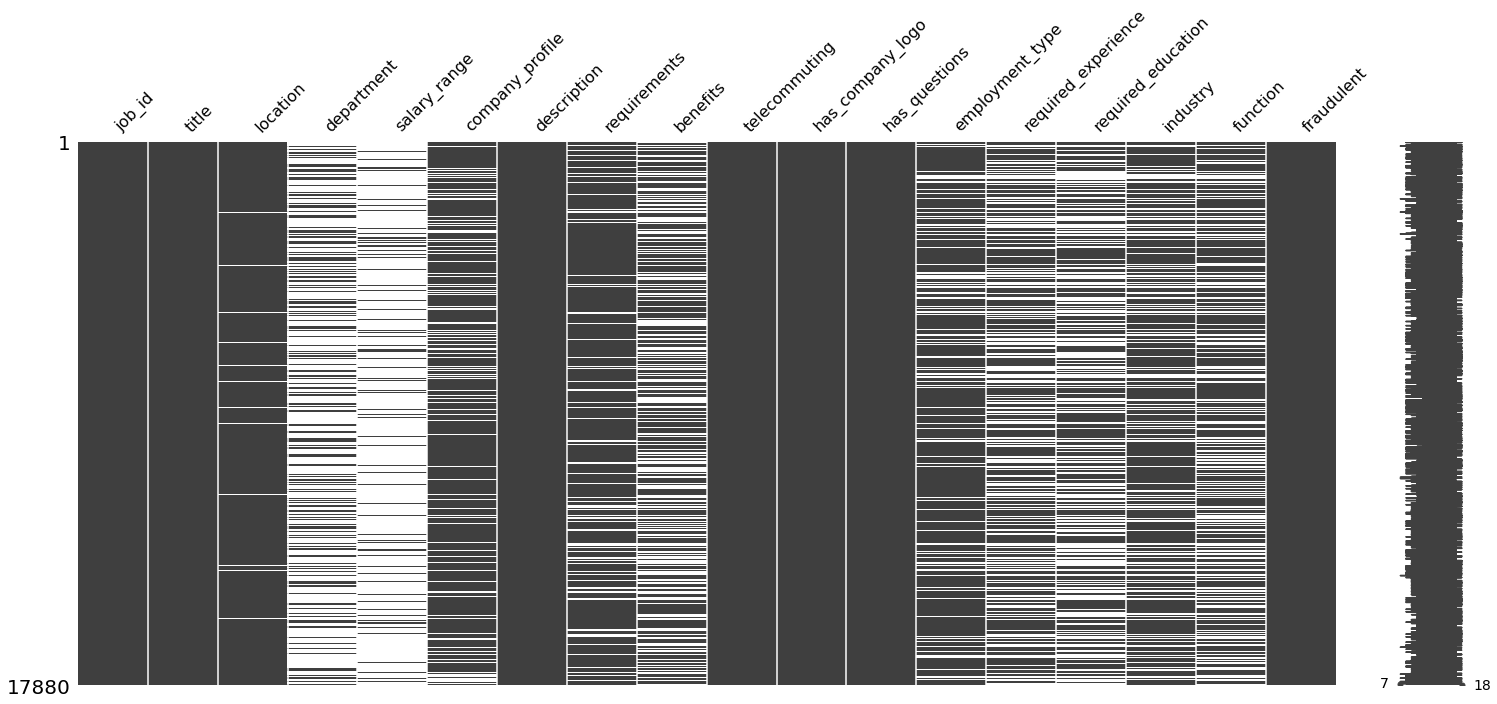

In [10]:
missingno.matrix(df)


From describing our data we get to know that their are 4 columns named as job_id, telecommuting, has_company_logo and has_questions features which have numerical data. So we can easily remove these columns as they are of no use in text classification problems.
We can also see one numerical feature 'fraudulent' is basically column on which our model will be trained and predicted.

In [11]:
df=df.drop(['job_id','telecommuting','has_company_logo','has_questions'],axis=1)


In [12]:
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Other,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [13]:
df.fillna(' ',inplace=True)

In [14]:
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,,,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Let's check which country posts most number of jobs.

In [15]:
def getCountryName(ele):
    ele=str(ele)
    
    ele=ele.split(',')[0]
    return ele
    

In [16]:
df['country']=df['location'].apply(getCountryName)

In [17]:
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Other,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,Full-time,Mid-Senior level,,Computer Software,Sales,0,CA
17876,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,US
17877,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",,,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,Full-time,,,,,0,US
17878,Graphic Designer,"NG, LA, Lagos",,,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,Contract,Not Applicable,Professional,Graphic Design,Design,0,NG


In [18]:
label_df=df['country'].value_counts()[:10].index


In [19]:
val_df=df['country'].value_counts()[:10].values



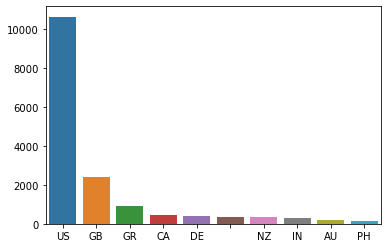

In [20]:
sns.barplot(x=label_df,y=val_df)
plt.show()

# Let's check about which type of experience is required in most number of jobs.

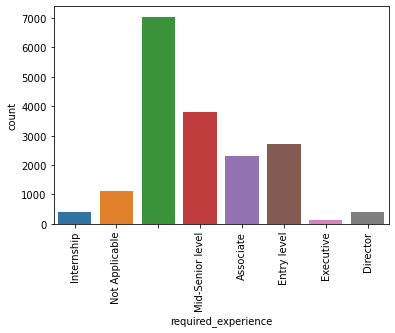

In [21]:
sns.countplot(df['required_experience'])
plt.xticks(rotation=90)
plt.show()

In [22]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'country'],
      dtype='object')

In [23]:
df['text']=df['title']+' '+df['location']+' '+df['department']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']

In [24]:
del df['salary_range']

In [25]:
del df['employment_type']

In [26]:
del df['required_experience']

In [27]:
del df['required_education']

In [28]:
del df['industry']

In [29]:
del df['function']

In [30]:
del df['country']

In [31]:
del df['title']

In [32]:
del df['location']

In [33]:
del df['department']

In [34]:
del df['company_profile']

In [35]:
del df['description']

In [36]:
del df['requirements']

In [37]:
del df['benefits']

In [38]:
df

,fraudulent,text
0,0,"Marketing Intern US, NY, New York Marketing We..."
1,0,"Customer Service - Cloud Video Production NZ, ..."
2,0,"Commissioning Machinery Assistant (CMA) US, IA..."
3,0,"Account Executive - Washington DC US, DC, Wash..."
4,0,"Bill Review Manager US, FL, Fort Worth SpotS..."
...,...,...
17875,0,"Account Director - Distribution CA, ON, Toron..."
17876,0,"Payroll Accountant US, PA, Philadelphia Accoun..."
17877,0,Project Cost Control Staff Engineer - Cost Con...
17878,0,"Graphic Designer NG, LA, Lagos Nemsia Stud..."


Now lets see what type of words are frequent in fraud and actual jobs using wordclouds



In [39]:
fraudjobs_text = df[df.fraudulent==1].text
actualjobs_text = df[df.fraudulent==0].text


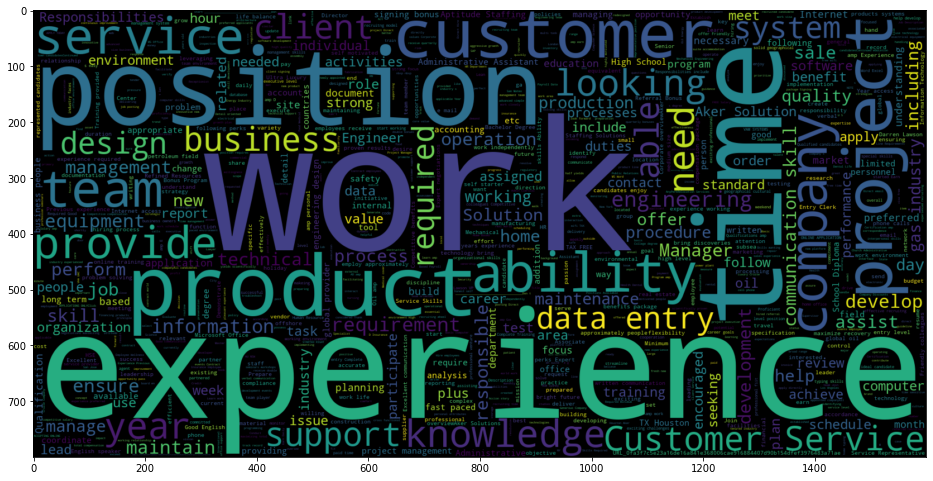

In [40]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

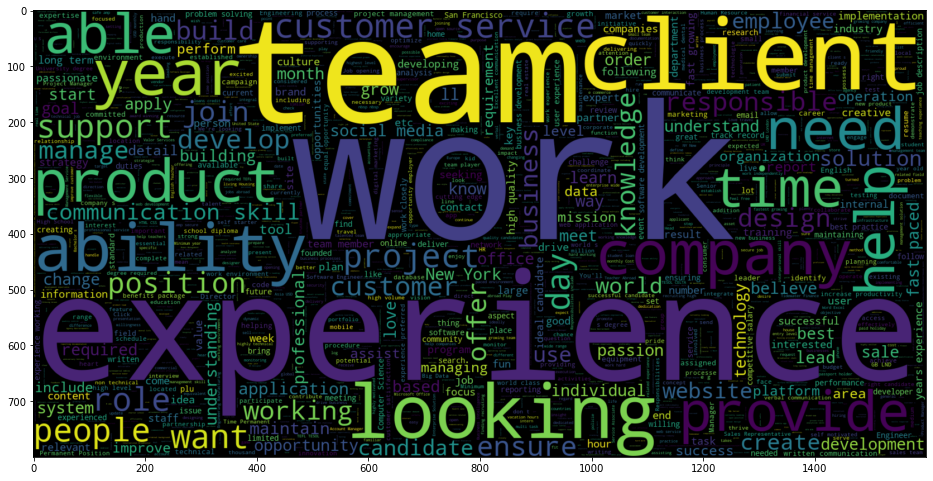

In [41]:
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

In [42]:
import nltk

In [43]:
from nltk.stem import PorterStemmer

In [44]:
from nltk.corpus import stopwords

In [45]:
import string

In [46]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himanshu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [47]:
ps=PorterStemmer()

In [48]:
def transform_text(text):
    text=text.lower()
    text=nltk.word_tokenize(text)
    
    y=[]
    
    for i in text:
        if i.isalnum():
            y.append(i)
    text=y[:]
    
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text=y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
    return " ".join(y)

In [49]:
df['text']=df['text'].apply(transform_text)

In [50]:
X_train,X_test,y_train,y_test = train_test_split(df.text,df.fraudulent,test_size=0.2)

In [51]:
print(X_train.shape)

(14304,)


In [52]:
print(X_test.shape)

(3576,)


In [53]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),  
    ('RF',RandomForestClassifier())
])

In [54]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('RF', RandomForestClassifier())])

In [55]:
y_pred = clf.predict(X_test)


In [56]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3417
           1       1.00      0.58      0.74       159

    accuracy                           0.98      3576
   macro avg       0.99      0.79      0.86      3576
weighted avg       0.98      0.98      0.98      3576



In [57]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),  
    ('LR',LogisticRegression())
])

In [58]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('LR', LogisticRegression())])

In [59]:
y_pred = clf.predict(X_test)


In [60]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3417
           1       0.95      0.36      0.52       159

    accuracy                           0.97      3576
   macro avg       0.96      0.68      0.75      3576
weighted avg       0.97      0.97      0.96      3576



In [61]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),  
    ('KN',KNeighborsClassifier())
])

In [62]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('KN', KNeighborsClassifier())])

In [63]:
y_pred = clf.predict(X_test)


In [64]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3417
           1       0.80      0.70      0.74       159

    accuracy                           0.98      3576
   macro avg       0.89      0.84      0.87      3576
weighted avg       0.98      0.98      0.98      3576



In [71]:
import xgboost as xgb

In [73]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),  
    ('XGBoost',xgb.XGBClassifier())
])

In [74]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('XGBoost',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimat

In [75]:
y_pred = clf.predict(X_test)


In [76]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3417
           1       0.93      0.62      0.74       159

    accuracy                           0.98      3576
   macro avg       0.95      0.81      0.87      3576
weighted avg       0.98      0.98      0.98      3576



In [77]:
#1. create a pipeline object
clf = Pipeline([
     ('vectorizer_tfidf',TfidfVectorizer()),  
    ('DT',DecisionTreeClassifier())
])

In [78]:
clf.fit(X_train,y_train)

Pipeline(steps=[('vectorizer_tfidf', TfidfVectorizer()),
                ('DT', DecisionTreeClassifier())])

In [79]:
y_pred = clf.predict(X_test)


In [80]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3417
           1       0.77      0.70      0.74       159

    accuracy                           0.98      3576
   macro avg       0.88      0.85      0.86      3576
weighted avg       0.98      0.98      0.98      3576

